# Packages

In [1]:
using Pkg; Pkg.activate("."); 
using TSO
using PyPlot
using Glob
using Serialization

  Activating environment at `/cobra/u/peitner/Turbospectrum/opacity_tables/TSO.jl/examples/converting_tables/Project.toml`


# Loading the Tables

In [2]:
paths = glob("OS_table*", "OPAC-for-3D/Z0.0a0.0");

In [3]:
mos = TSO.MARCSOpacity(paths...);

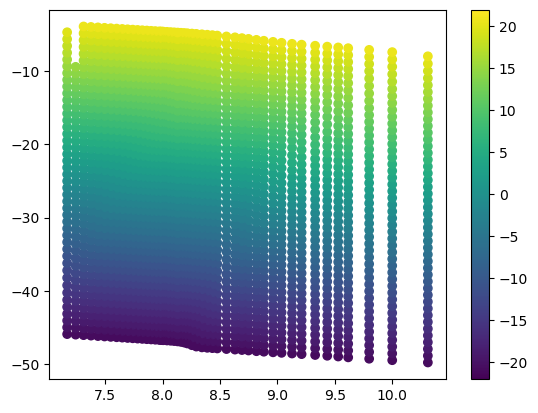

In [4]:
close()

for i in eachindex(mos)
    plt.scatter(log.(mos[i].T), log.(mos[i].ρ), c=log.(mos[i].pg), vmin=-22, vmax=22)
end

#plt.yscale("log")
#plt.xscale("log")
plt.colorbar()
gcf()

Load the tables after interpolation

In [5]:
m_int = deserialize("m_int");

In [6]:
tt, rr = TSO.meshgrid(m_int.T, m_int.ρ);

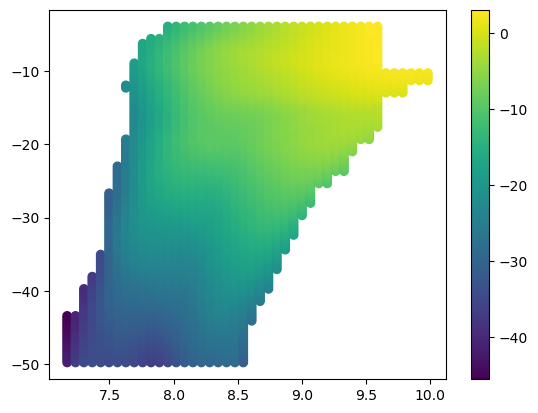

In [7]:
close()
plt.scatter(tt, rr, c=log.(m_int.κ_la[:, :, end]))
plt.colorbar()
gcf()

# Complement with EoS

The MARCS OS tables do not provide internal energy, which is why they need to be complemented with an EoS to get it. Any EoS may be used. The rosseland opacity can either compute by itself (which should be the prefered procedure) or take it from the EoS aswell. The rest can either be taken from this table or from the original EoS.

In [43]:
eos = TSO.reload(TSO.SqEoS, abspath("../../../tests/TSO_sun_Magg_v10.2/eos.hdf5"))
eosMARCS_c = TSO.reload(TSO.SqEoS, "TSO_MARCS_v1.2/combined_eos.hdf5")
opaMARCS_c = TSO.reload(TSO.SqOpacity, "TSO_MARCS_v1.2/combined_opacities.hdf5", mmap=false);

In [44]:
tt, rr = TSO.meshgrid(eosMARCS_c.lnT, eosMARCS_c.lnRho);

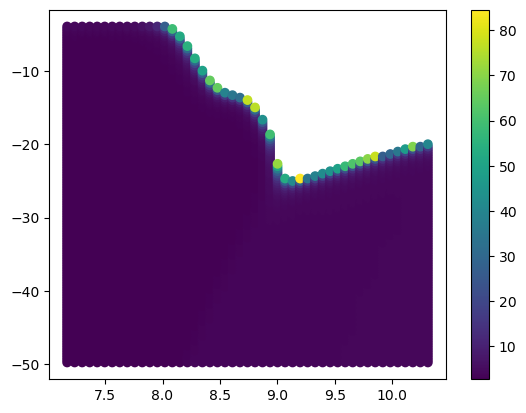

In [45]:
close()
plt.scatter(tt, rr, c=log.(opaMARCS_c.κ_ross[:, :]))
plt.colorbar()
gcf()

In [46]:
rosseland_opacity!(eosMARCS_c.lnRoss, eosMARCS_c, opaMARCS_c)

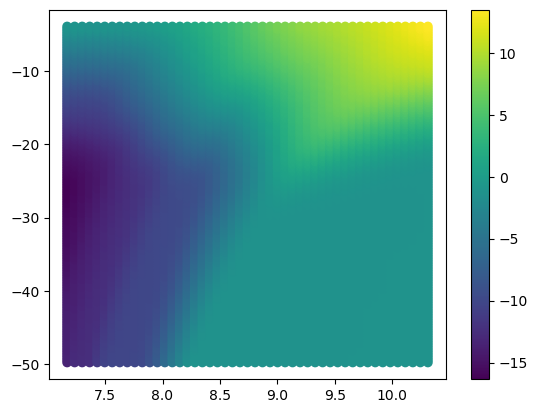

In [47]:
close()
plt.scatter(tt, rr, c=eosMARCS_c.lnRoss[:, :])
plt.colorbar()
gcf()

In [14]:
save(eosMARCS_c, "TSO_MARCS_v1.2/combined_ross_eos.hdf5")

"TSO_MARCS_v1.2/combined_ross_eos.hdf5"

In [28]:
model = Average3D(eosMARCS_c, "/u/peitner/Turbospectrum/opacity_tables/tests/stagger_av.dat");

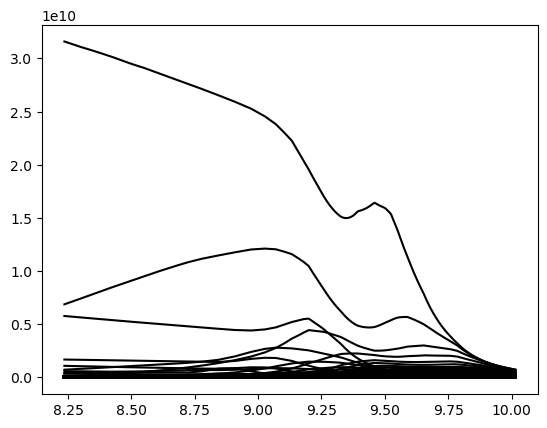

In [59]:
close()
for i in eachindex(opaMARCS_c.λ)
    plt.plot(model.lnT, lookup(eosMARCS_c, opaMARCS_c, :κ, model.lnρ, model.lnT, i), color="k")
end
gcf()

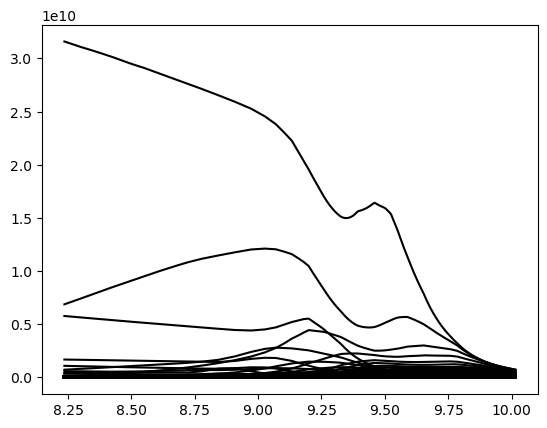

In [ ]:
close()
for i in eachindex(opaMARCS_c.λ)
    plt.plot(model.lnT, lookup(eosMARCS_c, opaMARCS_c, :κ, model.lnρ, model.lnT, i), color="k")
end
gcf()

In [29]:
aos = @axed eosMARCS_c
τ_ross, τ_λ = optical_depth(aos, opaMARCS_c, model);

(Float32[0.0010683647, 0.0033680198, 0.006016145, 0.009064077, 0.012574153, 0.016623283, 0.021303806, 0.026723305, 0.0330071, 0.040302537  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Float32[0.091224164 0.090184815 … 1.788616f-7 1.791521f-7; 0.2920609 0.28868482 … 5.9879284f-7 5.99765f-7; … ; 3.4339755f6 3.2655195f6 … 8.415724f10 8.4167705f10; 3.5262165f6 3.3559188f6 … 8.77697f10 8.7780614f10])

In [54]:
"""
Compute monochromatic and rosseland optical depth scales of the model 
based on the opacity table
"""
function optical_depth_test(eos, opacities, model)
    # Model z, ρ and T in cgs
    z, lnρ, lnE = model.z, model.lnρ, TSO.is_internal_energy(eos) ? model.lnEi : model.lnT

    T = eltype(opacities.κ)

    τ_λ    = zeros(T, length(lnρ), length(opacities.λ)) 
    τ_ross = zeros(T, length(lnρ)) 
    ρκ     = zeros(T, length(lnρ))
    κ      = zeros(T, length(lnρ))

    @show lnρ lnE eos.energy_axes.name eos.density_axes.name limits(eos) TSO.lookup(eos, opacities, :κ, lnρ, lnE, 1)

    # For each wavelength we integrate along z, z[1]-> surface, z[end]-> bottom
    for i in eachindex(opacities.λ)
        # Look up the opacity in the table
        κ  .= TSO.lookup(eos, opacities, :κ, lnρ, lnE, i)
        ρκ .= exp.(lnρ) .* κ

        # Integrate: τ(z) = [ ∫ ρκ dz ]_z0 ^z
        for j in eachindex(z)
            if j==1 
                τ_λ[1, i] = 0 + (z[2] - z[1]) * 0.5 * (ρκ[j])
            else
                τ_λ[j, i] = τ_λ[j-1, i] + (z[j] - z[j-1]) * 0.5 * (ρκ[j] + ρκ[j-1])
            end
        end
    end

    # Rosseland optical depth
    κ  .= TSO.lookup(eos, opacities, :κ_ross, lnρ, lnE)
    ρκ .= exp.(lnρ) .* κ
    for j in eachindex(z)
        if j==1 
            τ_ross[1] = 0 + (z[2] - z[1]) * 0.5 * (ρκ[j])
        else
            τ_ross[j] = τ_ross[j-1] + (z[j] - z[j-1]) * 0.5 * (ρκ[j] + ρκ[j-1])
        end
    end

    return τ_ross, τ_λ
end

optical_depth_test

In [55]:
optical_depth_test(aos, opaMARCS_c, model)

lnρ = [-23.180305, -23.038437, -22.898151, -22.757418, -22.616014, -22.472094, -22.326553, -22.17929, -22.030994, -21.881187, -21.727142, -21.575111, -21.424795, -21.27544, -21.122316, -20.969488, -20.81828, -20.668592, -20.520252, -20.37172, -20.22086, -20.07129, -19.922897, -19.775576, -19.629223, -19.483742, -19.339056, -19.192413, -19.046585, -18.901573, -18.757318, -18.613771, -18.470892, -18.328684, -18.187214, -18.046547, -17.90671, -17.767748, -17.629745, -17.492844, -17.357222, -17.2231, -17.090734, -16.960321, -16.82989, -16.702192, -16.577465, -16.453613, -16.3337, -16.215525, -16.101145, -15.990183, -15.882578, -15.779253, -15.680527, -15.586876, -15.499036, -15.418509, -15.347705, -15.2908745, -15.252261, -15.230015, -15.217839, -15.210577, -15.201424, -15.185758, -15.163024, -15.135569, -15.105362, -15.073789, -15.040459, -15.004757, -14.967333, -14.92862, -14.888798, -14.848353, -14.80768, -14.766625, -14.725, -14.683303, -14.641719, -14.600127, -14.558592, -14.517151, -

(Float32[0.0010683647, 0.0033680198, 0.006016145, 0.009064077, 0.012574153, 0.016623283, 0.021303806, 0.026723305, 0.0330071, 0.040302537  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], Float32[0.091224164 0.090184815 … 1.788616f-7 1.791521f-7; 0.2920609 0.28868482 … 5.9879284f-7 5.99765f-7; … ; 3.4339755f6 3.2655195f6 … 8.415724f10 8.4167705f10; 3.5262165f6 3.3559188f6 … 8.77697f10 8.7780614f10])

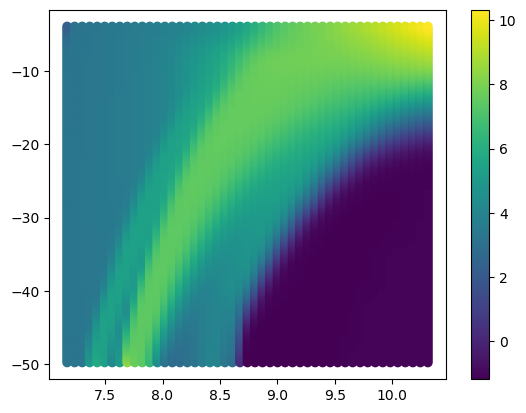

In [34]:
close()
plt.scatter(tt, rr, c=log.(opaMARCS_c.κ[:, :, 1]))
plt.colorbar()
gcf()

In [22]:
τ_λ

238×107855 Matrix{Float32}:
 0.0912242  0.0901848  0.0900096  …  1.79038f-7  1.78862f-7  1.79152f-7
 0.292061   0.288685   0.288124      5.99378f-7  5.98793f-7  5.99765f-7
 0.533754   0.527459   0.526437      1.16508f-6  1.16396f-6  1.16585f-6
 0.823835   0.813923   0.812352      1.92433f-6  1.9225f-6   1.92562f-6
 1.16739    1.1531     1.15088       2.93813f-6  2.93537f-6  2.94014f-6
 1.57728    1.55765    1.55467    …  4.30048f-6  4.29648f-6  4.30347f-6
 2.06181    2.03565    2.03176       6.13763f-6  6.13197f-6  6.14196f-6
 2.62154    2.58758    2.58264       8.6023f-6   8.59447f-6  8.60846f-6
 3.26429    3.22118    3.21502       1.18953f-5  1.18846f-5  1.19039f-5
 4.00514    3.95126    3.94369       1.63135f-5  1.62991f-5  1.63255f-5
 ⋮                                ⋱                          
 2.84429f6  2.68843f6  2.61205f6     6.20042f10  6.20119f10  6.20196f10
 2.9228f6   2.76517f6  2.68729f6  …  6.48539f10  6.48619f10  6.48699f10
 3.00318f6  2.84377f6  2.76438f6     6.78035f1

In [20]:
d_ross, d_κ = formation_height(model, aos, opaMARCS_c, τ_ross, τ_λ)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = Float32[-6.841626, -5.6934304, -5.1133084, -4.7034364, -4.376112, -4.096951, -3.8488696, -3.6222193, -3.4110327, -3.211341, -3.020065, -2.8353167, -2.6561208, -2.481641, -2.3107703, -2.1426291, -1.976905, -1.8134297, -1.6520374, -1.4924605, -1.334205, -1.1769983, -1.0208452, -0.8657256, -0.711613, -0.55845743, -0.40620986, -0.25460392, -0.10343868, 0.047277857, 0.1975622, 0.34742105, 0.49689445, 0.6459971, 0.79477614, 0.94326806, 1.0914909, 1.239506, 1.3873065, 1.5349691, 1.6825154, 1.8299615, 1.9773725, 2.124669, 2.2721686, 2.4199777, 2.567917, 2.7162461, 2.864875, 3.0140133, 3.1639814, 3.3149126, 3.4684694, 3.62606, 3.7877116, 3.954241, 4.138091, 4.3533225, 4.64963, 5.416271, 23.028933, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, In

(Float32[0.010873186, 0.010998791, 0.01101875, 0.011019589, 0.011016524, 0.0007778732, 0.010939179, 0.011005731, 0.011013812, 0.008126538  …  15.054008, 15.053333, 15.052319, 15.051628, 15.05037, 15.050009, 15.048644, 15.043979, 15.047002, 15.04538], Float32[1584.2661, 1555.4537, 1552.5342, 1552.458, 1553.1058, 19883.756, 1564.5789, 1555.611, 1553.7437, 2270.8958  …  42.014427, 42.018143, 42.02131, 42.023674, 42.025406, 42.029312, 42.032692, 42.033653, 42.037342, 42.038815])